In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

# Credit Risk Scoring

In [3]:
!wget $data

--2025-11-07 09:13:17--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.009s  

2025-11-07 09:13:17 (20.3 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [2]:
df=pd.read_csv('CreditScoring.csv')

In [3]:
df.columns=df.columns.str.lower().str.replace(' ', '_')

In [4]:
status_values = {
     1:'ok', 
     2:'default', 
     0:'unk'
}
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)
df.status=df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)

In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [6]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [7]:
for c in ['income', 'assets', 'debt']:
    df[c]=df[c].replace(to_replace=99999999, value=np.nan)

In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [9]:
df=df[df.status != 'unk'].reset_index(drop=True)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [12]:
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

In [13]:
y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values

In [14]:
del df_train['status']
del df_test['status']
del df_val['status']

## Decision Trees

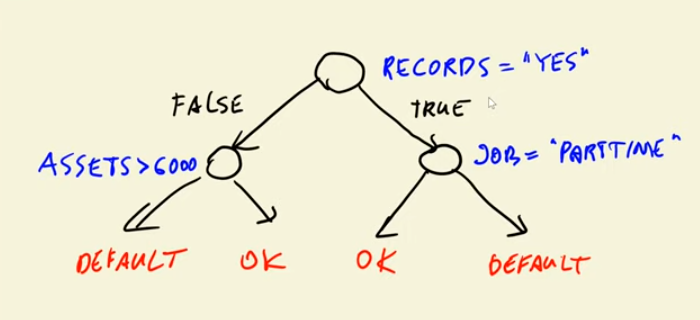

coded with if-else conditions/rules

**pseudo-code** 

    if client has prev 'records' then:
        if client's job is partime then:
            return 'default'
        else:
            if client's assets > X then:
                return 'ok'
            else:
                return 'default'

**these rules/conditions will be learnt by our model from the data, instead of us hardcoding/encoding it**

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [16]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [17]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [18]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [19]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [20]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
# auc on val data
y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on val:{auc}")

# auc on train data 
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print(f"AUC on train:{auc}")

AUC on val:0.7389079944782155
AUC on train:0.7761016984958594


In [22]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



**^^problem of overfitting**

why this happens?

    - Because of the specificity of rules. Ex. one customer passes conditional checks and is classed as 'default'.. the model will memorize this and predict the same status for another person with similar conditions. Especially because the depth of the dree can even be infinite. 

**To counter the depth issue, we can restrict the depth.**

## Decision Tree Algo

In [23]:
data = [[8000, 'default'],
        [2000, 'default'],
        [0, 'default'],
        [5000, 'ok'],
        [5000, 'ok'],
        [4000, 'ok'],
        [9000, 'ok'],
        [3000, 'default']]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example        

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [24]:
ts = [0,2000,3000,4000,5000,8000] #thresholds for ASSETS > T

In [25]:
from IPython.display import display

In [26]:
for t in ts:
    print(t)
    df_left = df_example[df_example.assets <= t]
    df_right = df_example[df_example.assets > t]
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64


#### to understand how good our predictions are - we take a look at `misclassification rate` - aka `Impurity`.

say our t = 4000 

then the split looks like this 

    	assets	status
    1	2000	default
    2	0	default
    5	4000	ok
    7	3000	default

df_left - misclassification rate = 1/4 = 25%

            assets	status
    0	8000	default
    3	5000	ok
    4	5000	ok
    6	9000	ok


df_right - misclassification rate = 1/4 = 25% (how may are wrongly classified -> 1 is okay out of 4)


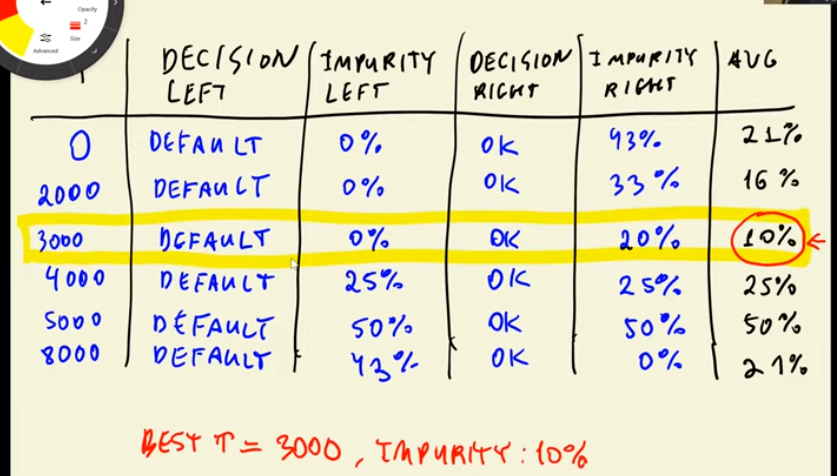

now, let's use two features - assets + debts, 

In [27]:
data = [[8000, 3000,'default'],
        [2000, 1000,'default'],
        [0, 1000,'default'],
        [5000, 1000,'ok'],
        [5000, 1000,'ok'],
        [4000, 1000,'ok'],
        [9000, 500,'ok'],
        [3000, 2000,'default']]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


##### now we split by debt

In [28]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


**so possible thresholds are 500, 1000, 2000**

In [29]:
thresholds = {
    'assets':[0,2000,3000,4000,5000,8000],
    'debt':[500,1000,2000]
}
for feature,ts in thresholds.items():
    print('*******************************')
    for t in ts:
        print(t)
        df_left = df_example[df_example[feature] <= t]
        df_right = df_example[df_example[feature] > t]
        
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        

*******************************
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64
*******************************
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64


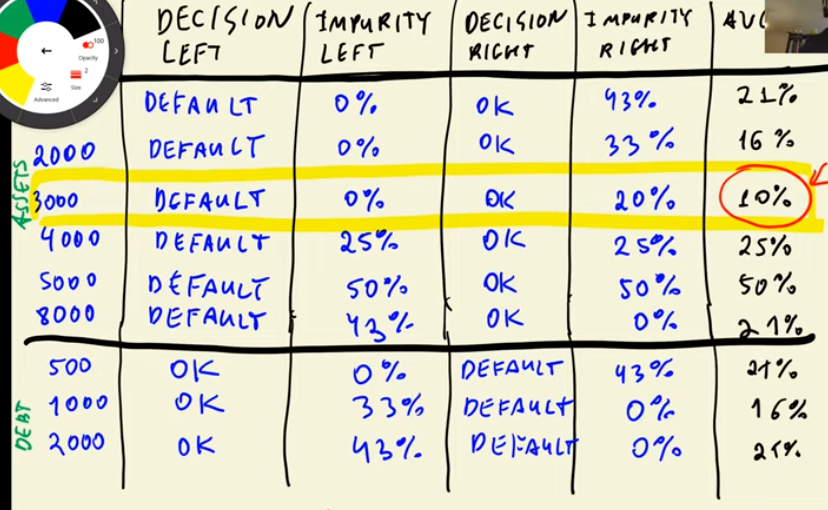

**as we can see, assets with t=3000 is still the best (has least impurity) - so we do our split by assets and not debt**


therefore, 

    for f in features:
        find number of thresholds for f 
        for t in thresholds:
            split dataset using 'F>T' condition
            compute the impurity of this split

    select the condition with the lowest impurity

depth of the tree is an indicator of splits within splits 

ex. if the split for assets > 3000, then left has 3 records, and right has 5 records

    we can further split the right into more left,right pairs
    
    while it doesn't make sense to split when it's only 3,5 but if your dataframe has say 800 records, then left becomes 300 and right becomes 500 in which case, it makes sense to split - this is where `depth` comes into picture. 
    
    we recursively apply splitting but when do we decide to stop?

stopping criterias:

    - group already pure 
    - tree reached depth limit
    - group is too small to split (like above 3,5 example)

**SUMMARY**
  
Decision Tree learning Algo:

    - Find the best split 
    - Stop if MAX_DEPTH is reached 
    - If LEFT is sufficiently large and not pure:
        repeat for left. 
    - If RIGHT is sufficiently large and note pure:
        repeat for right

## Decision Tree Parameter Tuning

- **selecting `max_depth`** - A “split” means a condition on one feature, and each time you add a new condition deeper in the tree, you increase the depth by 1.
Not “per feature overall” — it’s per condition node on any feature.

    So, `max_depth` is how far down you can go/how many questions you can consequently ask before the model starts to overfit (get too specific) 


- **selecting `min_samples_leaf`** - how many samples must be in the final group before it can qualify for a conclusion (ex. let's say we have a group of 20 students and we're assessing something - if only kid is in the final group (end of decision tree) - it's not good enough, so you want at least 3 kids to be in tht group before you make a final deciison.).

    If you let the tree split and split, it might make tiny leaves like:
    
    “People who are 37 years old, earn 60,200, live in ZIP code 94109, and have exactly one late payment”
    — and that leaf only has 2 people in it!
    
    That’s too specific — it’s memorizing instead of learning.
    
    **Therefore, if a potential split makes a group smaller than `min_samples_leaf`, then don't make that split - this prevents overfitting.**



In [30]:
for d in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d,auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.754
  10 -> 0.692
  15 -> 0.678
  20 -> 0.647
None -> 0.645


**best depth - 4,5,6 (best among the three is still `5`)**

In [35]:
scores = []
for d in [4,5,6,7,10,15,20,None]:
    for l in [1,2,5,10,15,20,100,200,500]: # min_samples_leaf
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=l)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d,l,auc))

In [36]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values('auc', ascending=False).head(5)

,max_depth,min_samples_leaf,auc
40,10.0,15,0.789736
49,15.0,15,0.787702
67,NaN,15,0.787554
58,20.0,15,0.786978
22,6.0,15,0.785695


In [37]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

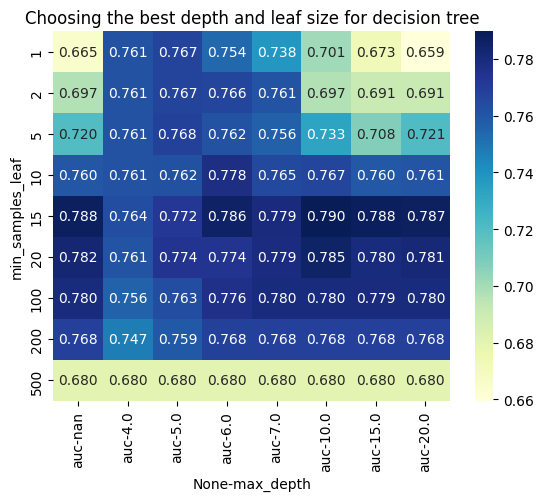

In [38]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Choosing the best depth and leaf size for decision tree')
plt.show()

auc - 10, min_samples_leaf - 15 >> best performance. 

but since auc - 6, and min_samples_leaf - 15 is only 0.04 less, it would still do.  
    

In [41]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train) 

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Ensembles & Random Forest